In [1]:
import sys
# n_runs = int(sys.argv[1])
n_runs = 512

oup_mc_fname = '/sdf/scratch/kipac/delon/toy_model_LIMxCMBL/monte_carlo_toy_model_nrun_%d.pkl'%(n_runs)
print(oup_mc_fname)

/sdf/scratch/kipac/delon/toy_model_LIMxCMBL/monte_carlo_toy_model_nrun_512.pkl


/sdf/group/kipac/users/delon/miniconda3/lib/python3.12/site-packages/pyccl/pk2d.py:285: RuntimeWarning: divide by zero encountered in log
  lk_use = np.log(k_use)
100%|██████████| 50/50 [00:00<00:00, 143.44it/s]


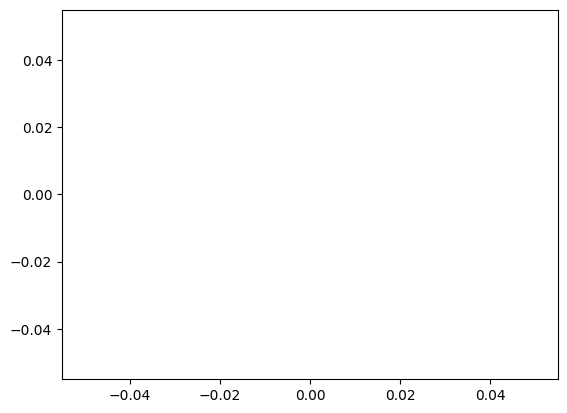

In [2]:
import matplotlib.pyplot as plt
from LIMxCMBL.toy import *

plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 10,
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1,
    'figure.figsize': (6, 6/1.618),
    'figure.constrained_layout.use': True,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})

In [3]:
LC_k = 'magenta'
nLC_color = 'cyan'
nLC_lw = 3
color = {'LC': 'k', 'nLC':'k'}

/sdf/group/kipac/users/delon/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/sdf/group/kipac/users/delon/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


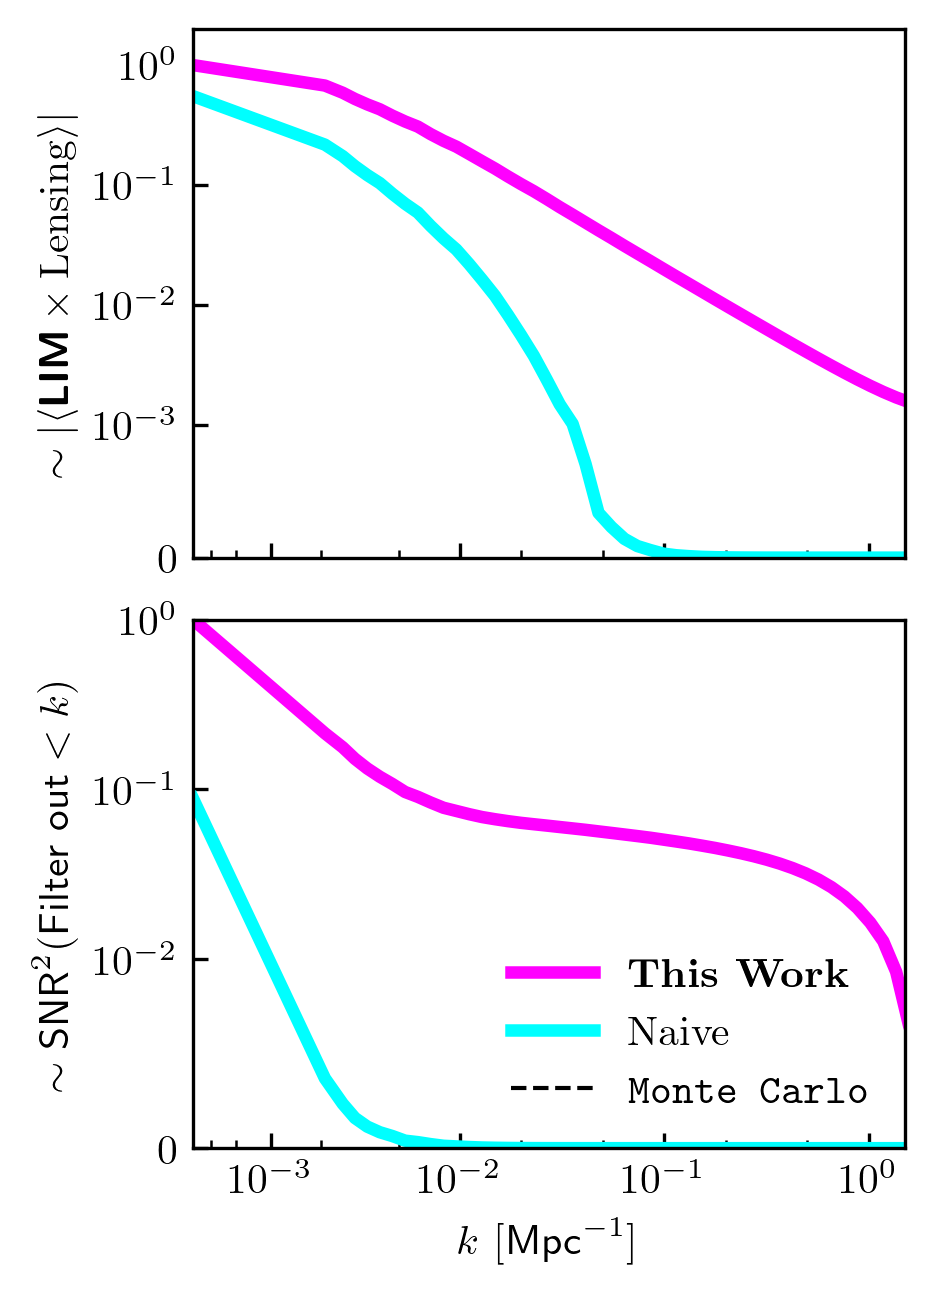

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3,4.2), dpi=300)
# <Ik> plot
def _plot(x, y, **params):
    axs[0].plot(x, jnp.abs(y/binned_Ik_kappa[0]), **params)
    


_plot(k_bin_centers, binned_Ik_kappa, 
         label=r'\textbf{This Work}', c=LC_k, lw=3)

_plot(k_bin_centers, binned_Ik_kappa_noLC, 
         label='Naive', c=nLC_color, lw=nLC_lw, ls='-')


axs[0].plot([-100, -99, ], [-1000000, -1000000], c='k', ls='--', label=r'\texttt{Monte Carlo}')

axs[0].set_yscale('symlog', linthresh=1e-3)
axs[0].set_ylim(0, 2)

axs[0].set_ylabel(r'$\sim |\langle \textbf{\textsf{LIM}}\times \rm{Lensing}\rangle|$')

# SNR2 Plot
def _plot(x, y, **params):
    axs[1].plot(x, y/SNR2s['theoryLC'][0], **params)

_plot(k_bin_centers, SNR2s['theoryLC'], c=LC_k, lw=3, label=r'\textbf{This Work}')
_plot(k_bin_centers, SNR2s['theorynLC'], c=nLC_color, lw=nLC_lw, label='Naive')

axs[1].errorbar([0, 100], [100, 100], lw=1, c='k', ls='--', label=r'\texttt{Monte Carlo}')

axs[1].set_yscale('symlog', linthresh=1e-2)
axs[1].set_ylim(0, 1e0)

axs[1].set_ylabel(r'$\sim {\sf SNR}^2(\textsf{Filter out}<k)$')
axs[1].set_xlabel(r'$k$ [${\sf Mpc}^{-1}$]')

plt.xscale('asinh', linear_width=1e-3)
plt.xticks([1e-3, 1e-2, 1e-1, 1])
plt.xlim(0, 1.5)

axs[1].legend(frameon=False)

In [5]:
_idx_bins = jnp.arange(n_k_bins)

In [6]:
@jax.jit
def get_fields(key):
    white_x = jax.random.normal(key, shape=(len(chis))) / jnp.sqrt(dchi)
    white_k = jnp.fft.fft(white_x) * dchi
    delta_m_k = jnp.sqrt(P1Dk) * white_k
    delta_m_x = jnp.real(jnp.fft.ifft(delta_m_k/dchi))

    kappa = dchi * jnp.sum(Kkappa_x*delta_m_x)
    
    I_x = KI * delta_m_x
    I_k = jnp.fft.fft(I_x) * dchi

    I_x_noLC = KIbar * delta_m_x
    I_k_noLC = jnp.fft.fft(I_x_noLC) * dchi

    IIstar = I_k.reshape(-1, 1) * jnp.conj(I_k).reshape(1, -1)
    IIstar_noLC = I_k_noLC.reshape(-1, 1) * jnp.conj(I_k_noLC).reshape(1, -1)

    

    return (kappa, 
            bin_Ik_vmapped(_idx_bins, I_k), 
            bin_Ik_vmapped(_idx_bins, I_k_noLC), 
            delta_m_k, 
            delta_m_x, 
            bin_cov_vmapped(jnp.arange(n_k_bins), jnp.arange(n_k_bins), IIstar), 
            bin_cov_vmapped(jnp.arange(n_k_bins), jnp.arange(n_k_bins), IIstar_noLC))


@jax.jit
def get_observable(key):
    kappa, I_k, I_k_noLC, delta_m_k, delta_m_x, IIstar, IIstar_noLC = get_fields(key)
    
    return [kappa**2, 
            kappa*I_k, 
            kappa*I_k_noLC, 
            IIstar,
            IIstar_noLC,]

In [7]:
key = jax.random.key(n_runs)


measured_spectra = {}


process = {
        'kk':     [0, np.array(expected_kappa2), 1],
        'LC_Ik' : [1, np.array(binned_Ik_kappa), n_k_bins],
        'nLC_Ik': [2, np.array(binned_Ik_kappa_noLC), n_k_bins],
        'LC_II':  [3, np.array(expected_binned_II), (n_k_bins, n_k_bins), ],
        'nLC_II': [4, np.array(expected_binned_II_noLC), (n_k_bins, n_k_bins), ],
}

for _type in process:
    measured_spectra[_type] = np.zeros(process[_type][-1], dtype=np.complex128)
    measured_spectra[_type+'_MSE'] = np.zeros(process[_type][-1])

In [8]:
for run in trange(n_runs):
    new_key, subkey = jax.random.split(key)
    del key
    
    observables = get_observable(subkey)
    del subkey

    key = new_key

    for _type in process:
        _idx, _expected, _shape = process[_type]
        measured_spectra[_type] += observables[_idx]
        measured_spectra[_type+'_MSE'] += jnp.real((observables[_idx]-_expected)*jnp.conj(observables[_idx]-_expected))

100%|██████████| 512/512 [09:58<00:00,  1.17s/it]


In [9]:
with open(oup_mc_fname, 'wb') as f:
    pickle.dump(measured_spectra, f)

In [10]:
estimated_kk = measured_spectra['kk']/n_runs
print((estimated_kk - expected_kappa2)/expected_kappa2)

[0.09239137+0.j]


Text(0, 0.5, '$|\\langle I(k)\\kappa\\rangle|$')

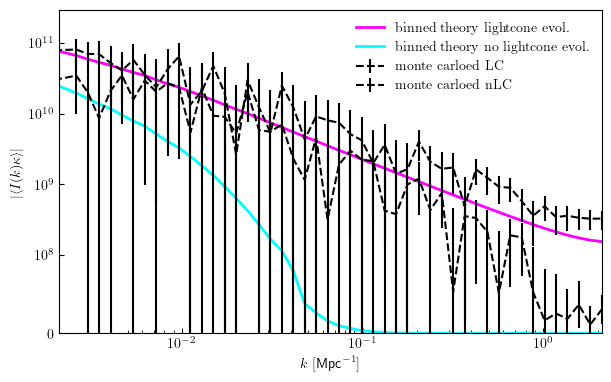

In [11]:
plt.plot(k_bin_centers, jnp.abs(binned_Ik_kappa), label='binned theory lightcone evol.', c='magenta', lw=2)
plt.plot(k_bin_centers, jnp.abs(binned_Ik_kappa_noLC), label='binned theory no lightcone evol.', c='cyan', lw=2)


color = {'LC': 'k', 'nLC':'k'}
for _type in ['LC', 'nLC']:
    curr_spectra = jnp.abs(measured_spectra[_type+'_Ik'] / n_runs)
    binned_rmse = jnp.sqrt(measured_spectra[_type+'_Ik_MSE'] / n_runs / (n_runs-1))
    plt.errorbar(k_bin_centers, curr_spectra, yerr=jnp.real(binned_rmse),
                 label='monte carloed %s'%_type, ls='--', c=color[_type])

plt.legend(frameon=False)

plt.yscale('symlog', linthresh=1e8)
plt.ylim(0, None)

# plt.xscale('symlog', linthresh=1e-3)
plt.xscale('log')
plt.xlim(k_bin_centers[1], k_bin_centers[-1])

plt.xlabel(r'$k$ [${\sf Mpc}^{-1}$]')
plt.ylabel(r'$|\langle I(k)\kappa\rangle|$')

In [12]:
SNR2s = {'LC':np.zeros(n_k_bins, dtype=np.complex128), 'nLC': np.zeros(n_k_bins, dtype=np.complex128),
         'theoryLC':np.zeros(n_k_bins, dtype=np.complex128), 'theorynLC': np.zeros(n_k_bins, dtype=np.complex128),}

In [13]:
theory_covs = {'LC': expected_binned_cov, 'nLC': expected_binned_cov_noLC}
theory_Ik = {'LC': binned_Ik_kappa, 'nLC': binned_Ik_kappa_noLC}

In [14]:
for _type in ['LC', 'nLC']:
    for kill_idx in trange(n_k_bins):
        #throw out k <= k_bin_edge[kill_idx]
        _estimated_II = measured_spectra[_type+'_II']/n_runs
        _estimated_Ik = measured_spectra[_type+'_Ik']/n_runs
        _estimated_cov = estimated_kk * _estimated_II + _estimated_Ik.reshape(-1, 1) * jnp.conj(_estimated_Ik.reshape(1, -1))

        x,resid,rank,s = jnp.linalg.lstsq(_estimated_cov[kill_idx:, kill_idx:], 
                                          jnp.conj(_estimated_Ik[kill_idx:]))
        SNR2s[_type][kill_idx] = (_estimated_Ik[kill_idx:] @ x)

        x,resid,rank,s = jnp.linalg.lstsq(theory_covs[_type][kill_idx:, kill_idx:], 
                                          jnp.conj(theory_Ik[_type][kill_idx:]))
        SNR2s['theory'+_type][kill_idx] = (theory_Ik[_type][kill_idx:] @ x)

100%|██████████| 49/49 [00:00<00:00, 229.55it/s]


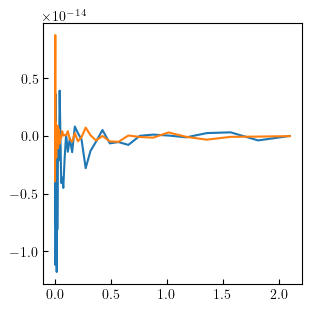

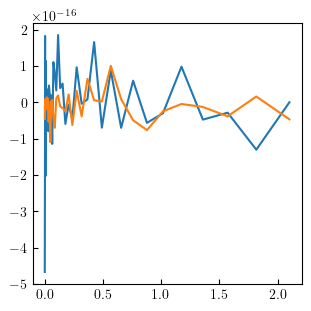

In [15]:
#checking the realty of the SNR (it should be)
for _type in ['LC', 'nLC']:
    plt.figure(figsize=(3,3))
    plt.plot(k_bin_centers,
             np.imag(SNR2s[_type])/np.real(SNR2s[_type]))
    plt.plot(k_bin_centers,
             np.imag(SNR2s['theory'+_type])/np.real(SNR2s['theory'+_type]))

    plt.show()
for _type in SNR2s:
    SNR2s[_type] = np.real(SNR2s[_type])

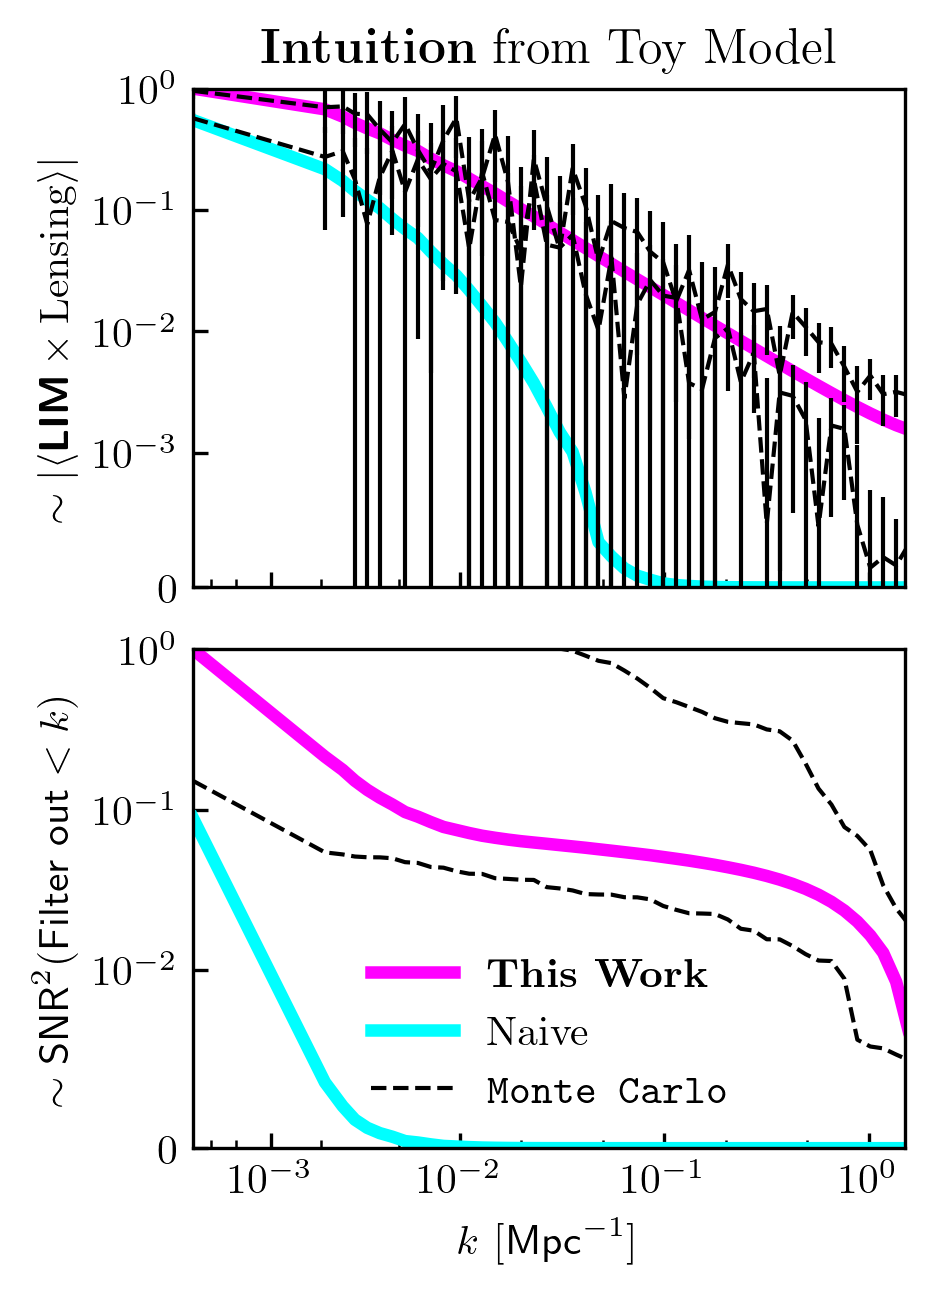

In [16]:
LC_k = 'magenta'
nLC_color = 'cyan'
nLC_lw = 3
color = {'LC': 'k', 'nLC':'k'}

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3,4.2), dpi=300)

axs[0].set_title(r'\textbf{Intuition} from Toy Model')

# <Ik> plot
def _plot(x, y, **params):
    axs[0].plot(x, jnp.abs(y/binned_Ik_kappa[0]), **params)
    
_plot(k_bin_centers, binned_Ik_kappa, 
         label=r'\textbf{This Work}', c=LC_k, lw=3)

_plot(k_bin_centers, binned_Ik_kappa_noLC, 
         label='Naive', c=nLC_color, lw=nLC_lw, ls='-')

for _type in ['LC', 'nLC']:
    curr_spectra = jnp.abs(measured_spectra[_type+'_Ik']) / n_runs
    binned_rmse = jnp.sqrt(measured_spectra[_type+'_Ik_MSE'] / n_runs / (n_runs - 1))
    # if(_type == 'LC'):
    #     binned_rmse = jnp.zeros_like(binned_rmse)
        
    axs[0].errorbar(k_bin_centers, curr_spectra/np.abs(binned_Ik_kappa)[0], 
                    yerr=jnp.abs(binned_rmse)/np.abs(binned_Ik_kappa)[0], 
                    lw=1,
                    ls='--', c=color[_type])



axs[0].plot([-100, -99, ], [-1000000, -1000000], c='k', ls='--', label=r'\texttt{Monte Carlo}')

axs[0].set_yscale('symlog', linthresh=1e-3)
axs[0].set_ylim(0, 1)

axs[0].set_ylabel(r'$\sim |\langle \textbf{\textsf{LIM}}\times \rm{Lensing}\rangle|$')
# axs[0].set_xlabel(r'$k$ [${\sf Mpc}^{-1}$]')



# SNR2 Plot
def _plot(x, y, **params):
    axs[1].plot(x, y/SNR2s['theoryLC'][0], **params)

_plot(k_bin_centers, SNR2s['theoryLC'], c=LC_k, lw=3, label=r'\textbf{This Work}')
_plot(k_bin_centers, SNR2s['theorynLC'], c=nLC_color, lw=nLC_lw, label='Naive')

for _type in ['LC', 'nLC']:
    _plot(k_bin_centers, SNR2s[_type], c=color[_type], lw=1, ls='--')
    
# _plot(Lambdas, SNR2s_proj, c='lightgrey', lw=1)
# _plot(Lambdas, jnp.real(estimated_Ik_proj**2/estimated_var_proj), 
#          c='yellow', lw=1, ls='--')

axs[1].errorbar([0, 100], [100, 100], lw=1, c='k', ls='--', label=r'\texttt{Monte Carlo}')


# axs[1].set_yscale('log')
# axs[1].set_ylim(1e-6,2e0)
axs[1].set_yscale('symlog', linthresh=1e-2)
axs[1].set_ylim(0, 1e0)


axs[1].set_ylabel(r'$\sim {\sf SNR}^2(\textsf{Filter out}<k)$')
axs[1].set_xlabel(r'$k$ [${\sf Mpc}^{-1}$]')

plt.xscale('asinh', linear_width=1e-3)
plt.xticks([1e-3, 1e-2, 1e-1, 1])
plt.xlim(0, 1.5)

# axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

# plt.savefig('figures/_015.005_%d.pdf'%(n_runs), bbox_inches = 'tight')